<a href="https://colab.research.google.com/github/chldbwls/cv_2025/blob/main/hw2_Choiyoujin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

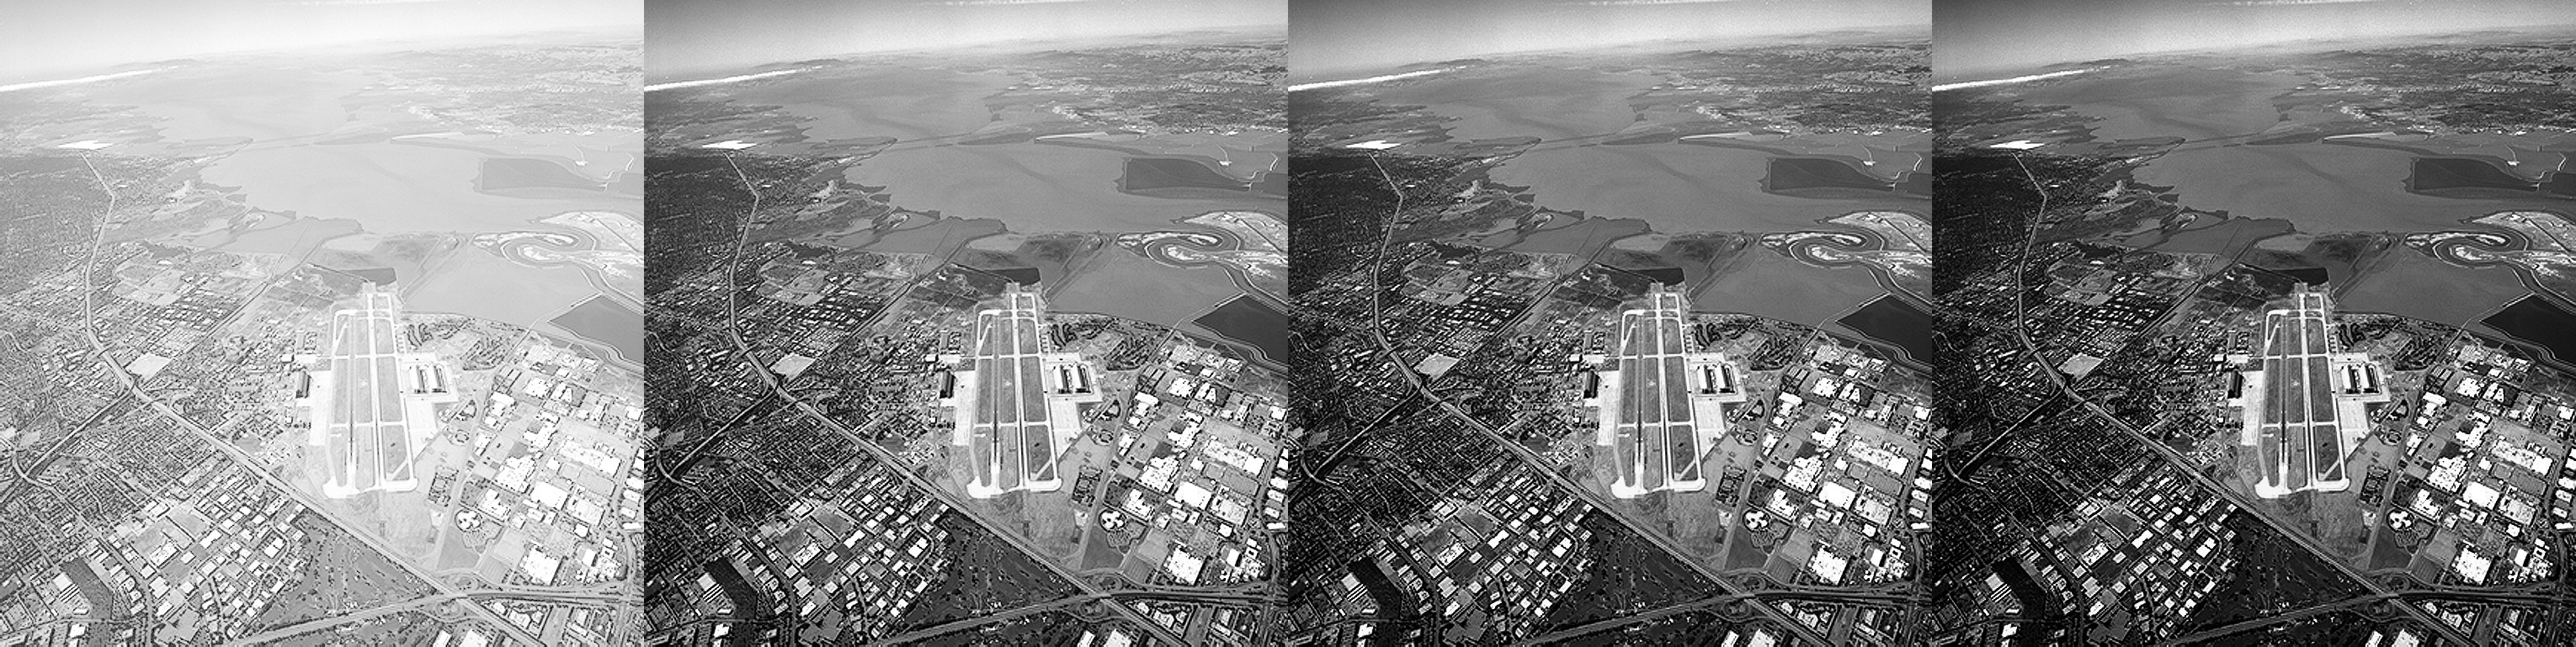

In [71]:
#1번
import cv2
import numpy as np
import urllib.request
from google.colab.patches import cv2_imshow    # colab에서 cv.imshow 사용


# 과제 pdf에 올라온 이미지 주소를 복사하여 url로 이미지를 불러오도록 하였습니다.
# 과제 이미지를 다운 받았는데 파일 이름이 이상해서 url로 받아오는 방법을 선택하였습니다.
url = 'https://raw.githubusercontent.com/kjcheoi-class/CV/main/Fig0309(a)(washed_out_aerial_image).tif'
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype=np.uint8)
# url로 이미지를 불러오고, 실제 이미지로 변경하려면 decode가 꼭 필요함 (명암영상으로 받음)
img = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)

# 감마 보정
def gamma(f,gamma=1.0):
  f1=f/255.0 # numpy.float64형
  return np.uint8(255*(f1**gamma))  #numpy.unit8 형으로 변환

# numpy.hstack 함수로 이어붙이기
# 각각 과제에서 원하는 1.0, 3.0, 4.0, 5.0으로 지정하였다.
# 감마 값이 높아질수록 사진이 더 어두워진다
gc = np.hstack((gamma(img, 1.0), gamma(img, 3.0), gamma(img, 4.0),gamma(img, 5.0)))

# 강의 자료에 나온 imshow는 사용할 수 없다고 하여서 아래와 같이 사용해서 위에 작업 내용을 출력함
cv2_imshow(gc)

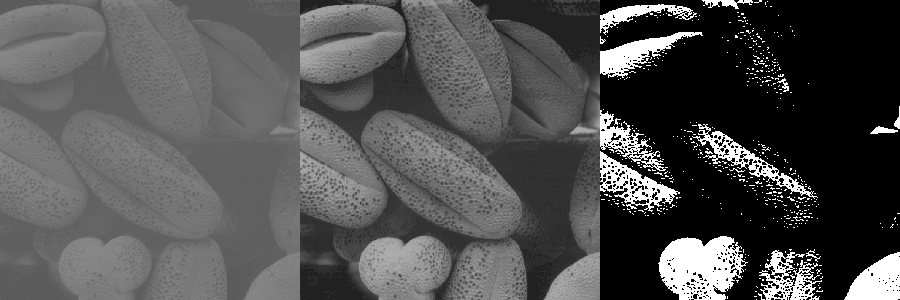

In [115]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import urllib.request

# 이미지 불러오기
url = 'https://raw.githubusercontent.com/kjcheoi-class/CV/main/Fig0310(b)(washed_out_pollen_image).tif'
resp = urllib.request.urlopen(url)
image_bytes = np.asarray(bytearray(resp.read()), dtype=np.uint8)
img = cv2.imdecode(image_bytes, cv2.IMREAD_GRAYSCALE)

img= cv2.resize(img,(300,300))

# 구간을 나누는 부분
# 강의 자료에서는 r1=L/4와 L/2의 중간인 3L/8로 약 90, s1은 L/4의 반인 L/8로 약 30정도로 보임
# r2는 L/2와 3L/4의 중간인 5L/8인 약 150, s2는 L-1과 3L/4의 중간인 (7L-4)/8정도로 약 220정도로 보인다
r1=90
s1=30
r2=150
s2=220

# 강의 자료에 있는 구간과 비슷하게 다 나눔
# 일단 원본 이미지랑 크기가 동일한 마스크 생성
mask = np.zeros((300,300), dtype = "uint8")
# 마스크의 행/열을 하나씩 돌면서
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
      # 아래 식은 선형 식으로 기울기를 구해주는것! (0,0 - 255,255라고 생각하고 위에 정해준 구간의 좌표와 함께 각 구간의 기울기를 구하면 됨)
        v = img[i, j]  # 원본 이미지 픽셀의 값을 불러와서
        if v <= r1: #만약에 픽셀 값 기준 첫번재 기준 값보다 작으면
            mask[i, j] = (s1 / r1) * v    #해당 픽셀에 대응하는 마스크의 픽셀 값은 기존 픽셀 값보다 높게 만들어서 넣어줌 -> 어두운 부분을 밝게
        elif v <= r2:   # 만약 픽셀 값 기준 두번째 기준 값보다 작은거면(대신 첫번째 기준 값보다는 큼)
            mask[i, j] = ((s2 - s1) / (r2 - r1)) * (v - r1) + s1  # 그래프에 그려진 것처럼 해주기만 하면 됨(기울기)
        else:  # 둘 다 아닌 경우 (픽셀값이 두번째 기준보다 높은 경우 - 임계값보다 밝은 경우임)
            mask[i, j] = ((255 - s2) / (255 - r2)) * (v - r2) + s2 # 기존 픽셀값보다 눌러서 너무 밝아보이지 않도록 만들어줌

# 이진화
t, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

# 출력
result = np.hstack((img, mask, binary))
cv2_imshow(result)



박스 마스크/가우시안 마스크/샤프닝 마스크



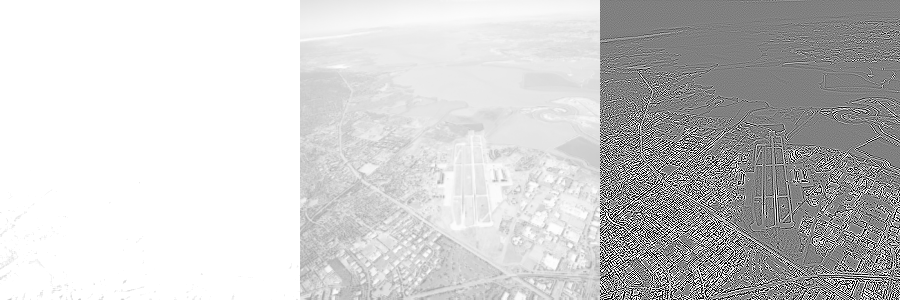

라플라시안 마스크/엠보싱 마스크/프레윗(대각선) 마스크



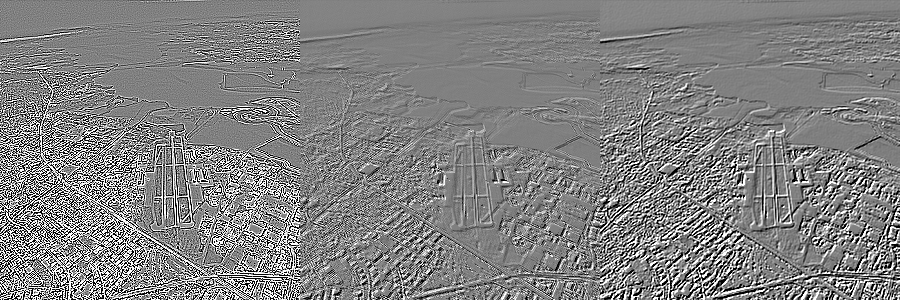

In [70]:
#3번
import cv2
import numpy as np
import urllib.request
from google.colab.patches import cv2_imshow

# 위와같이 url로 이미지를 불러오는 방법을 선택하였다.
# 임의의 영상을 사용해도 된다하며 1번과 동일한 영상을 사용하였다.
url = 'https://raw.githubusercontent.com/kjcheoi-class/CV/main/Fig0309(a)(washed_out_aerial_image).tif'
resp = urllib.request.urlopen(url)
img_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE) # url로 불러온 이미지를 사용하려면 꼭 해줘야 함

img=cv2.resize(img,(300,300))

# 필터 연산 중 음수가 나올 수 있으므로 16비트 정수로 변환
gray16 = np.int16(img)

#박스 마스크 : 정규 마스크
fbox = np.array([[1/9, 1/9, 1/9],
                 [1/9, 1/9, 1/9],
                 [1/9, 1/9, 1/9]])
# 참고자료에 있는 것 처럼 2D 컨볼루션 연산을 진행함
# 혹시 모를 음수 양수가 나올 수 있으므로 따로 처리해주었다.
# 아래도 동일하게 해주었다.
box=np.uint8(np.clip(cv2.filter2D(gray16,-1,fbox)+128,0,255))


# 가우시안 마스크 : 거리에 따라 가중치 부여
fgaussian = np.array([[0.0030, 0.0133, 0.0219],
                      [0.0133, 0.0596, 0.0983],
                      [0.0219, 0.0983, 0.1621]])
gaussian=np.uint8(np.clip(cv2.filter2D(gray16,-1,fgaussian)+128,0,255))

# 샤프닝 마스크 : 명암 대비 강조 효과 - 가운데를 기준으로 상하좌우 -1
fsharpen = np.array([[ 0, -1,  0],
                     [-1,  4, -1],
                     [ 0, -1,  0]])
sharpen=np.uint8(np.clip(cv2.filter2D(gray16,-1,fsharpen)+128,0,255))

# 라플라시안 필터 마스크
flaplacian = np.array([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]])
laplacian=np.uint8(np.clip(cv2.filter2D(gray16,-1,flaplacian)+128,0,255))

# 엠보싱 마스크 (참고자료와 동일)
femboss = np.array([[-1.0, 0.0, 0.0],
                    [ 0.0, 0.0, 0.0],
                    [ 0.0, 0.0, 1.0]])
emboss=np.uint8(np.clip(cv2.filter2D(gray16,-1,femboss)+128,0,255))

# 프레윗 연산자를 대각선에 맞게 변형해줌
fedge = np.array([[-1, -1, 0],
                  [-1,  0, 1],
                  [ 0,  1, 1]])
edge=np.uint8(np.clip(cv2.filter2D(gray16,-1,fedge)+128,0,255))

# 6개의 결과를 3개 3개로 나눠서 출력할 것
row1=np.hstack((box,gaussian,sharpen))
row2=np.hstack((laplacian,emboss,edge))

# 출력
print("박스 마스크/가우시안 마스크/샤프닝 마스크\n")
cv2_imshow(row1)
print("라플라시안 마스크/엠보싱 마스크/프레윗(대각선) 마스크\n")
cv2_imshow(row2)


원본이미지/45도 엣지 검출/-45도 엣지 검출



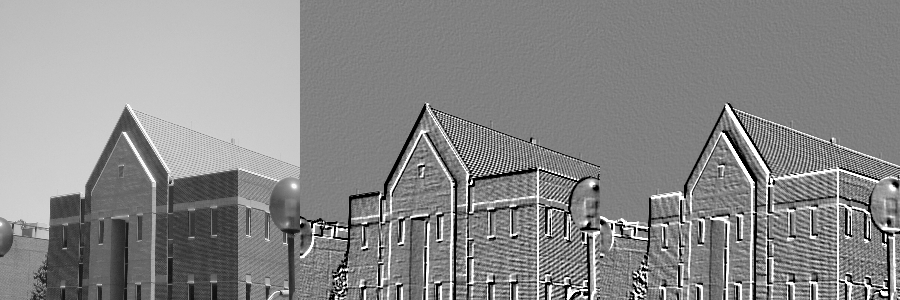

In [72]:
#4번
import cv2
import urllib.request
import numpy as np
from google.colab.patches import cv2_imshow

# 이미지 불러오기
url = 'https://raw.githubusercontent.com/kjcheoi-class/CV/main/school.jpg'
resp = urllib.request.urlopen(url)
img_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

img=cv2.resize(img,(300,300))
# 필터 연산 중 음수가 나올 수 있으므로 16비트 정수로 변환
gray16 = np.int16(img)

# 45도 엣지 검출하는 소벨 연산자 마스크
# 기존 소벨 연산자를 대각선에 맞게 돌려줌
edge_45_mask = np.array([
    [-2, -1,  0],
    [-1,  0, 1],
    [ 0, 1, 2]
])

# -45도 엣지를 검출하는 소벨 연산자 마스크
# 반대도 마찬가지로 기존 소벨 연산자를 대각선에 맞게 돌려줌(위와 반대 방향으로)
edge_m45_mask = np.array([
    [ 0, 1, 2],
    [-1,  0, 1],
    [-2, -1,  0]
])

# 필터 적용
edge_45 = np.uint8(np.clip(cv2.filter2D(gray16,-1,edge_45_mask)+128,0,255))
edge_m45 = np.uint8(np.clip(cv2.filter2D(gray16,-1,edge_m45_mask)+128,0,255))

# 하나로 묶어서 출력할거라서 묶어주었습니다.
result = np.hstack((img, edge_45, edge_m45))

# 결과 출력
print("원본이미지/45도 엣지 검출/-45도 엣지 검출\n")
cv2_imshow(result)


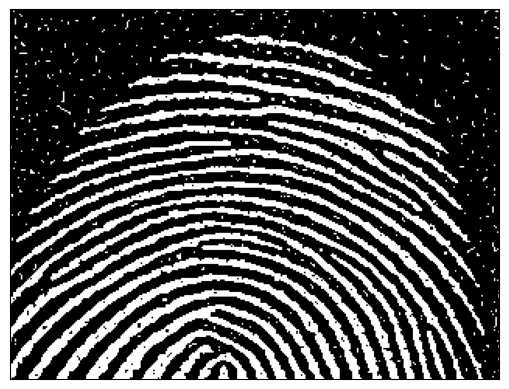

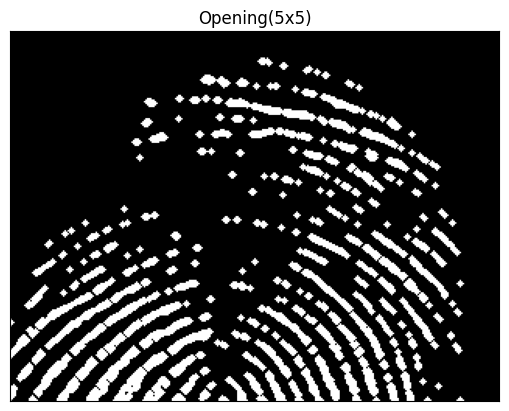

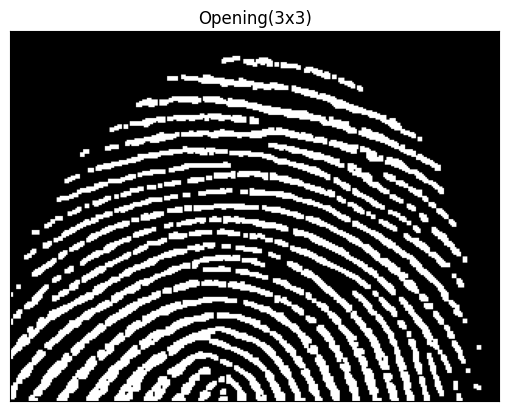

In [25]:
#5번
import cv2
import urllib.request
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# 이미지 불러오기 (그레이스케일로)
url = 'https://raw.githubusercontent.com/kjcheoi-class/CV/main/finger.jpg'
resp = urllib.request.urlopen(url)
img_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

# 이진화를 먼저 진행함 (OTSU를 활용하여)
t, bin_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# 참고자료에 plt로 출력하는 것이 나와서 여기서 plt를 사용하여 이미지를 출력함
plt.imshow(bin_img, cmap='gray'), plt.xticks([]), plt.yticks([])
plt.show()


# 구조 요소 5x5
# 참고자료에 나온 5x5 구조 요소를 사용함
se=np.uint8([[0,0,1,0,0],
            [0,1,1,1,0],
            [1,1,1,1,1],
            [0,1,1,1,0],
            [0,0,1,0,0]])

# 오프닝 연산2(5x5) (열기: 침식 후 팽창)
# opening 연산을 진행함 -> 침식을 한 후에 다시 팽창하면 됨
bin_opening = cv2.dilate(cv2.erode(bin_img, se, iterations=1), se, iterations=1)
plt.imshow(bin_opening, cmap='gray'), plt.xticks([]), plt.yticks([])
plt.title('Opening(5x5)')
plt.show()

# 출력을 해보니 노이즈는 사라졌는데 지문이 일부 보이지 않았습니다.
# 그래서 구조 요소를 5x5에서 3x3으로 줄여서 진행해보았습니다.
# 교수님이 주신 추가 자료에 있던 5x5행렬을 강의자료에 있는 3x3행렬로 변경했더니 좀 더 줄이 잘 보임!
se = np.uint8([[1,1,1],
               [1,1,1],
               [1,1,1]])

# 오프닝 연산2(3x3) (열기: 침식 후 팽창)
# 위와 동일하게 오프닝 연산을 진행해주었습니다
bin_opening = cv2.dilate(cv2.erode(bin_img, se, iterations=1), se, iterations=1)
plt.imshow(bin_opening, cmap='gray'), plt.xticks([]), plt.yticks([])
plt.title('Opening(3x3)')
plt.show()

# 3x3 구조 요소로 오프닝 연산을 해주니 더 잘보였습니다!


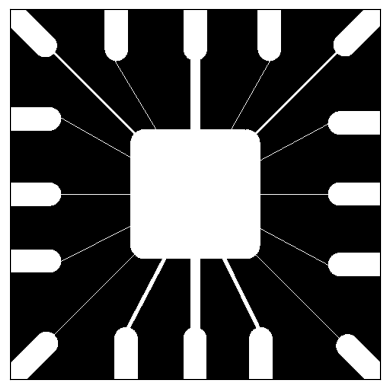

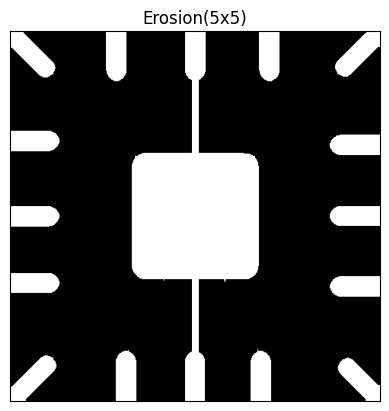

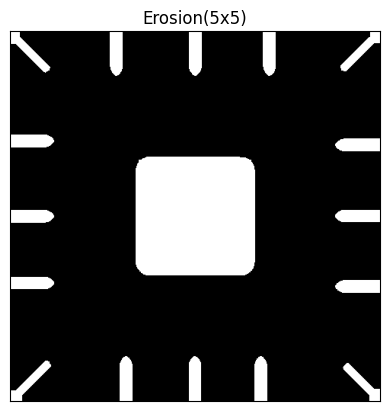

In [26]:
#6번
import cv2
import urllib.request
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# 이미지 불러오기 (그레이스케일로)
url = 'https://raw.githubusercontent.com/kjcheoi-class/CV/main/Fig0905(a)(wirebond-mask).tif'
resp = urllib.request.urlopen(url)
img_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

# 이진화를 먼저 진행 (OTSU)
_, bin_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(bin_img, cmap='gray'), plt.xticks([]), plt.yticks([])
plt.show()


# 구조 요소
se = np.uint8([[1,1,1,1,1],
               [1,1,1,1,1],
               [1,1,1,1,1],
               [1,1,1,1,1],
               [1,1,1,1,1]])

# 침식을 진행하면 얇은 선들을 제거할 수 있음
# 5x5 -> 위 아래 선(조금 두꺼운 선)을 제외 모두 제거됨
bin_ero = cv2.erode(bin_img, se, iterations=1)
plt.imshow(bin_ero, cmap='gray'), plt.xticks([]), plt.yticks([])
plt.title('Erosion(5x5)')
plt.show()

# 구조 요소
# 15x15 -> 위아래 선까지 모두 제거
# 15보다 작은 13x13으로 진행하면 얇은 선이 남음(15부터 아예 선이 사라짐)
se = np.uint8([[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]])

# 침식
bin_ero2= cv2.erode(bin_img, se, iterations=1)
plt.imshow(bin_ero2, cmap='gray'), plt.xticks([]), plt.yticks([])
plt.title('Erosion(5x5)')
plt.show()


소벨 연산자



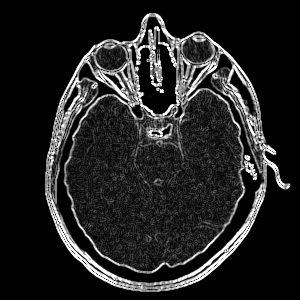

케니 엣지 검출



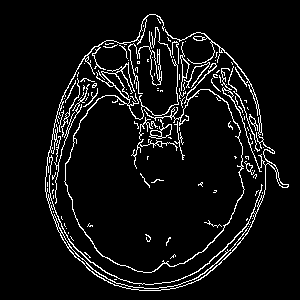

라플라시안 엣지 검출



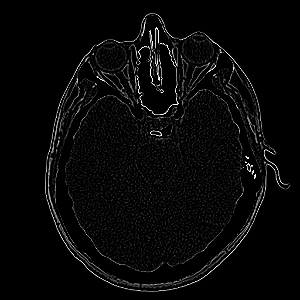

모폴로지컬 그레디언트 엣지 검출



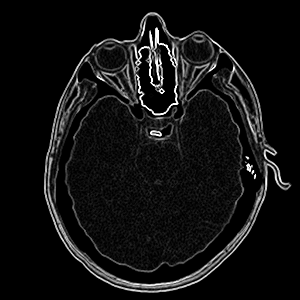

In [67]:
#7번
import cv2
import numpy as np
import urllib.request
from google.colab.patches import cv2_imshow

# 이미지 불러오기
url = 'https://raw.githubusercontent.com/kjcheoi-class/CV/main/Fig0939(a)(headCT-Vandy).tif'
resp = urllib.request.urlopen(url)
img_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

img=cv2.resize(img,(300,300))

# Sobel 3x3
grad_x=cv2.Sobel(img,cv2.CV_32F,1,0,ksize=3)
grad_y=cv2.Sobel(img,cv2.CV_32F,0,1,ksize=3)

sobel_x=cv2.convertScaleAbs(grad_x)	# 절대값을 취해 양수 영상으로 변환
sobel_y=cv2.convertScaleAbs(grad_y)

edge_strength=cv2.addWeighted(sobel_x,0.5,sobel_y,0.5,0)	# 에지 강도 계산
# 소벨 연산자를 활용한 에지 검출 결과 출력
print("소벨 연산자\n")
cv2_imshow(edge_strength)

# Canny
canny = cv2.Canny(img, 100, 200)
print("케니 엣지 검출\n")
cv2_imshow(canny)

# Laplacian
laplacian = cv2.Laplacian(img, cv2.CV_32F)
print("라플라시안 엣지 검출\n")
cv2_imshow(laplacian)

# Morphological Gradient
# 5x5 구조요소를 만들어서 모폴로지 연산을 진행(팽창)
se=np.uint8([[0,0,1,0,0],			# 구조 요소
            [0,1,1,1,0],
            [1,1,1,1,1],
            [0,1,1,1,0],
            [0,0,1,0,0]])

# 모폴로지 연산: 팽창
dilated = cv2.dilate(img, se)

# 팽창 - 원본이미지를 진행하여 엣지를 검출하였다.
# 원본이미지-침식으로 해도 된다고 강의시간에 들었는데, 여기서는 팽창을 시킨 다음에 원본이미지를 빼는 방식으로 진행했다!
# 강의 자료에서 형태학적 기울기 연산이 케니 에지 추출보다 낫다고 하였는데, 케니 에지에서는 에지가 부분도 에지로 인식하여 내부에 선을 긋는 반면, 확실히 형태학적 기울기 연산에서는 그런 부분이 없다
mor = cv2.subtract(dilated, img)
print("모폴로지컬 그레디언트 엣지 검출\n")
cv2_imshow(mor)


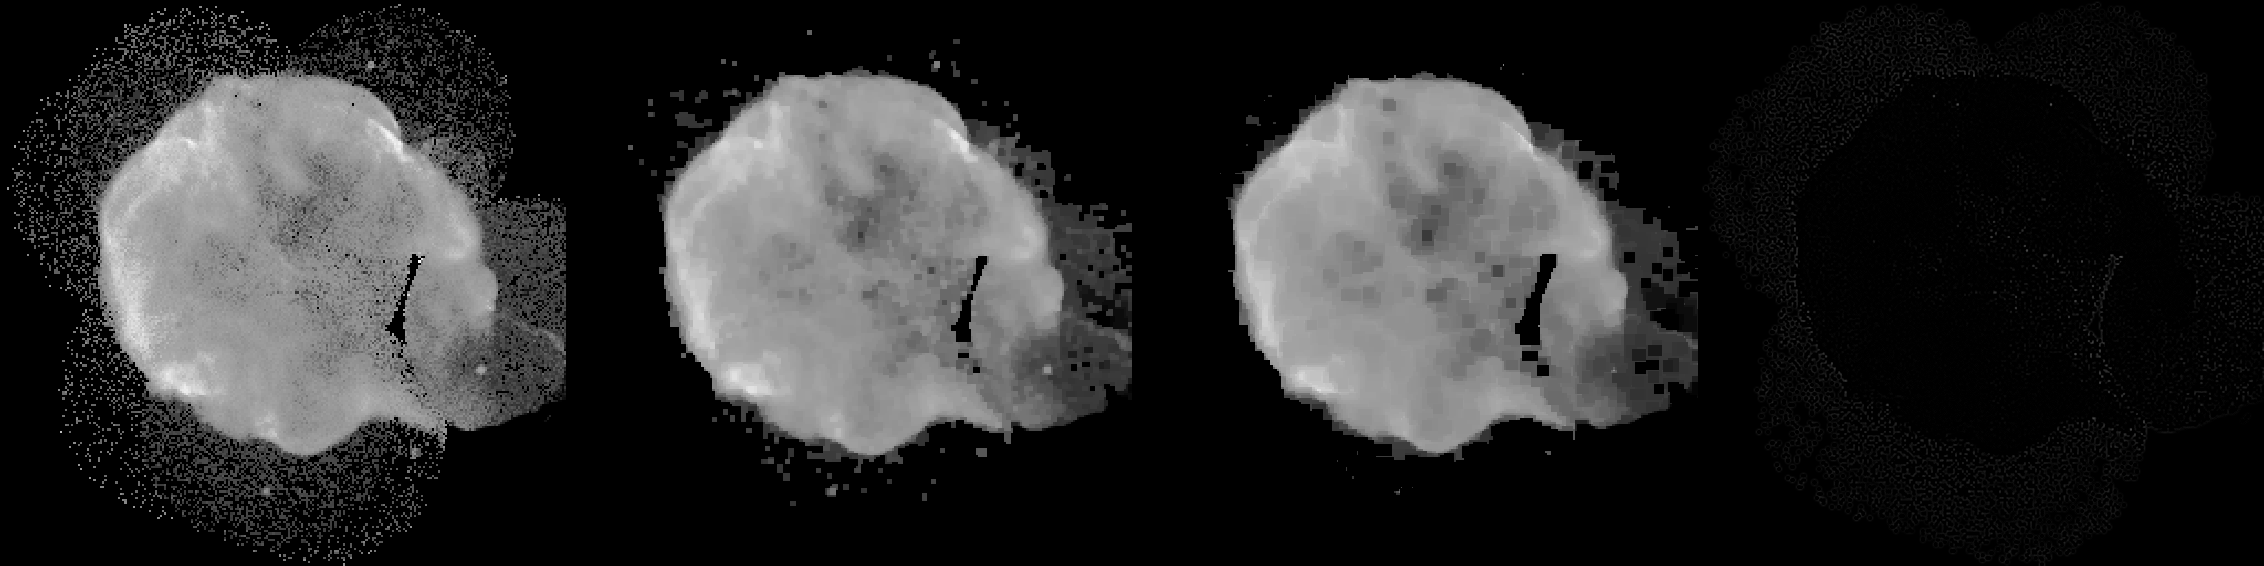

In [48]:
#8번
import cv2
import numpy as np
import urllib.request
from google.colab.patches import cv2_imshow

# 이미지 불러오기
url = 'https://raw.githubusercontent.com/kjcheoi-class/CV/main/Fig0938(a)(cygnusloop_Xray_original).tif'
resp = urllib.request.urlopen(url)
img_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)


# 열림 후 닫힘 연산(5)
# 5x5 구조요소를 만들어서 모폴로지 연산을 진행(팽창)
se=np.uint8([[1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1]])
opening = cv2.dilate(cv2.erode(img, se, iterations=1), se, iterations=1)
opening_closing = cv2.erode(cv2.dilate(opening, se, iterations=1), se, iterations=1)


# 열림 후 닫힘 연산(10) 숫자가 높아질수록 노이즈 제거가 잘됨
# 모폴로지 스무딩으로 하면 가운데가 아니라 겉에 점을 노이즈라고 생각
se2 = np.uint8([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])
opening2 = cv2.dilate(cv2.erode(img, se, iterations=1), se2, iterations=1)
opening_closing2 = cv2.erode(cv2.dilate(opening, se, iterations=1), se2, iterations=1)


# LoG: 가우시안 블러 후 라플라시안을 진행함
# 얘는 가운데 큰 부분도 노이즈라고 생각 (소금후추)
b = cv2.GaussianBlur(img, (5, 5), 0)
log = cv2.Laplacian(b, cv2.CV_32F)

# 형태학적 스무딩의 경우 겉에 있는 작은 점을 노이즈로 인식하여 없애는 반면, 스무딩 필터를 활용하였을 떄는 가운데 부분까지(흰부분 전부) 노이즈로 생각하여 없애버립니다
result1=np.hstack((img,opening_closing,opening_closing2,log))
cv2_imshow(result1)


원본 영상/tophat-otsu/그냥 otsu


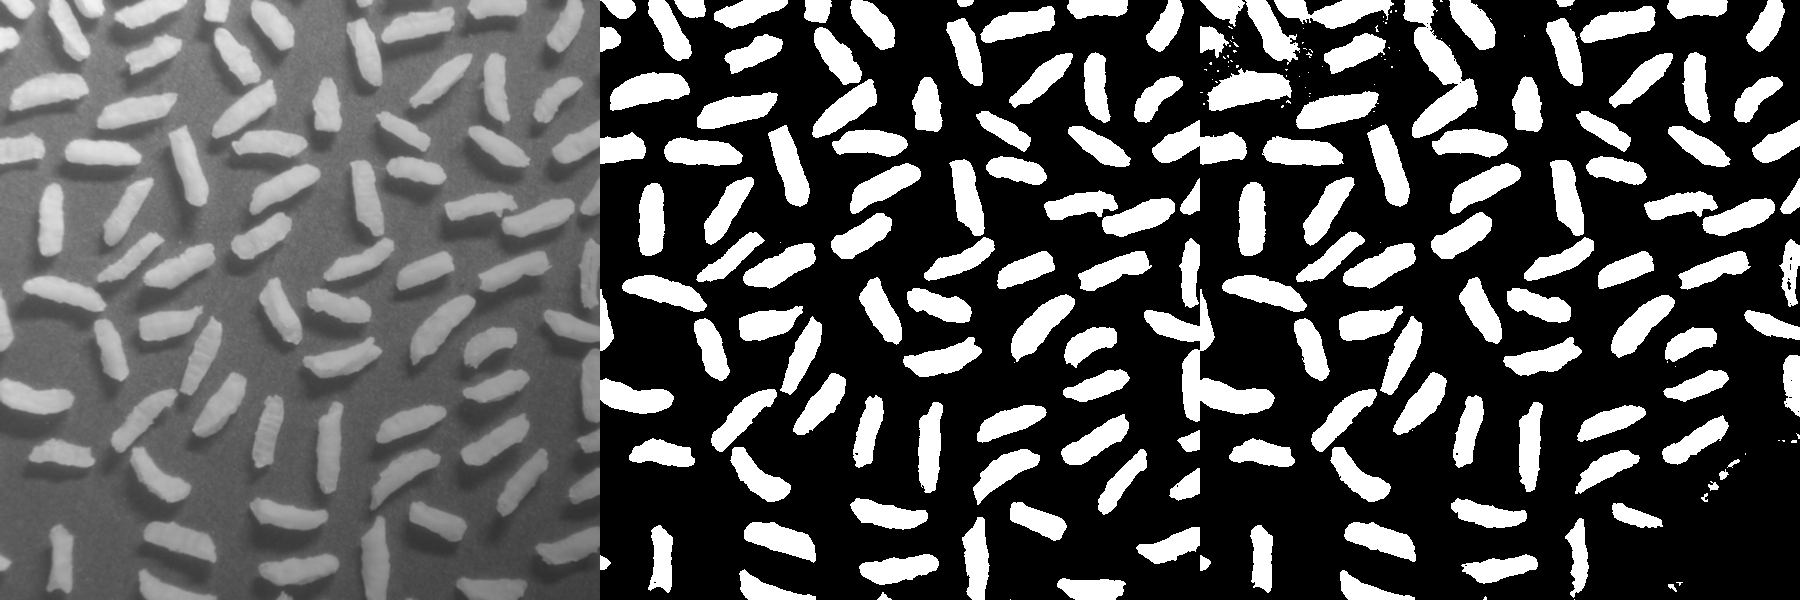

In [53]:
#9번
import cv2
import numpy as np
import urllib.request
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# 이미지 불러오기
url = 'https://raw.githubusercontent.com/kjcheoi-class/CV/main/Fig0940(a)(rice_image_with_intensity_gradient).tif'
resp = urllib.request.urlopen(url)
img_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

# 디스크 모양의 구조요소
# 강의 자료에서 반지름 크기가 40인 애를 사용한다고 하여서 반지름을 40으로 잡았습니다.
# 그래서 지름=80으로 두고 80x80 구조 요소로 진행하였습니다
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (80, 80))

# 강의 자료에서 반지름이 40인 구주요소를 사용해서 열림 연산을 하고, top-hat 변환을 해주면 된다고 하여 열림 연산 먼저 수행
# 열림 연산
opening = cv2.dilate(cv2.erode(img, se, iterations=1), se, iterations=1)

# White tophat
# 열림연산을 하고 원래 영상에서 해당 영상을 빼주는 과정입니다.
# 이렇게 하면 배경이 완벽히 균일하지는 않지만 밝/어두운 극값간의 차이가 줄어들게 됩니다.
tophat = cv2.subtract(img, opening)

#  Tophat 결과에 Otsu에 의한 이진화
t, tophat_otsu = cv2.threshold(tophat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 그냥 Otsu에 의한 이진화
t, only_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 결과를 보면 tophat 후 otsu를 진행한 영상은 원본 영상의 쌀알이 모두 보입니다
# 반면 otsu만 해준 영상의 경우 오른쪽 아래가 없어지거나, 좌측 위의 영상에 노이즈가 보입니다
print("원본 영상/tophat-otsu/그냥 otsu")
result=np.hstack((img,tophat_otsu,only_otsu))
cv2_imshow(result)



원본/닫힘 연산/열림 연산/열림 연산을 이진화/결과


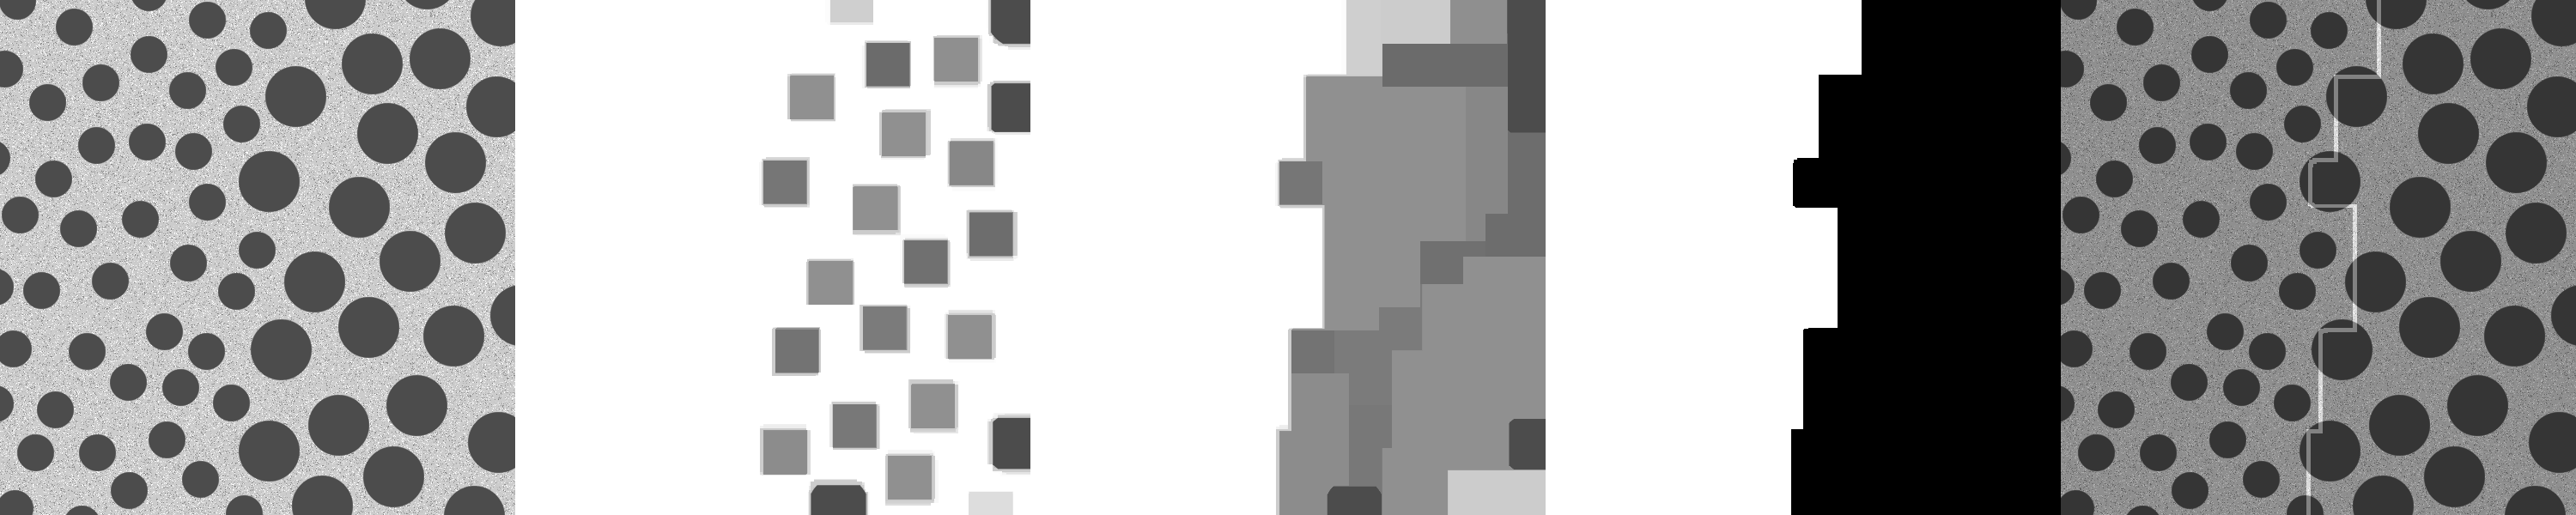

In [65]:
#10번
import cv2
import numpy as np
import urllib.request
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# 이미지 불러오기
url = 'https://raw.githubusercontent.com/kjcheoi-class/CV/main/Fig0943(a)(dark_blobs_on_light_background).tif'
resp = urllib.request.urlopen(url)
img_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)


# 구조 요소 크기 설정
se_s = np.ones((50, 50), np.uint8)  # 작은 얼룩보다 더 큰 구조 요소 (50으로 해야 좌측에 작은 점이 다 제거됨)
se_l = np.ones((100, 100), np.uint8)  # 간격에 비해 큰 구조 요소

# 닫힘 연산 -> 팽창 후 수축
# 좌측에 있는 점을 지우기 위하여 수행되므로 s를 통해 진행해줍니다
closing = cv2.erode(cv2.dilate(img, se_s, iterations=1), se_s, iterations=1)

# 열림 연산 -> 수축 후 팽창
# 남은 얼룩들 간의 밝은 패치를 제거 합니다 (l사용)
# 닫힘 연산한 이미지를 오프닝 해주는 것입니다
opening = cv2.dilate(cv2.erode(closing, se_l, iterations=1), se_l, iterations=1)

# 예시에 나와있는 사진처럼 다 같은 색으로 만들어 주기 위하여 제가 임의로 색이 있으면 그냥 다 검정색으로, 흰부분은 그냥 다 흰색으로 이진화해주었습니다
t, binary_image = cv2.threshold(opening, 225, 255, cv2.THRESH_BINARY)

# 열림 연산 후 이미지를 조금 더 팽창시키기 -> 에지 추출을 하기 위해서
# 대신 구조 요소를 작게 해줘서 아주 조금만 팽창시킵니다(에지를 좀 얇게 뽑기 위해서)
dilated= cv2.dilate(binary_image, np.ones((10, 10), np.uint8))

# 경계(에지)를 추출하기 위해서 열림 연산 이미지에서 팽창된 이미지를 빼줍니다
boundary_image = cv2.subtract(dilated, binary_image)

# 원본 이미지와 에지 이미지를 둘이 겹쳐보이게 해줍니다
result_image = cv2.addWeighted(img, 0.7, boundary_image, 0.3, 0)

# 출력
# 결과가 강의자료처럼 완전 매끄럽게 나오지는 않았지만 객체가 구분 될 정도로는 나왔다고 생각합니다 ..
result=np.hstack((img,closing,opening,binary_image,result_image))
print("원본/닫힘 연산/열림 연산/열림 연산을 이진화/결과")
cv2_imshow(result)

